In [1]:
#Library imports
import re
import os
import shutil
import time
import math
import fnmatch
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm

from IPython.display import Image, display
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from PIL import Image, ImageDraw, ImageOps

from tensorflow.keras import models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2


#User Created functions

from cleaning_functions import *
from eda_functions import *
from modeling_functions import *
from setup_functions import *

from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

#Notebook arguments
%matplotlib inline

In [2]:
#Without this block the Japanese font's won't display properly in Matplotlib.Set to your font directory.
extend_matplotlib_fonts("/usr/share/fonts/")

/home/anacuda/work/nyc-mhtn-ds-021720/japanese_text_classifiers/setup_functions.py:23: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


In [3]:
#Device specific gpu deterministic arguments
from tensorflow import config as tfconfig
physical_devices = tfconfig.list_physical_devices('GPU')
tfconfig.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
#Sets random seeds to allow for reproducable results.
from tensorflow import random as tfrandom
SEED=127
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tfrandom.set_seed(SEED)

Since there are many classes, I've imported a json that contains useful information about the characters and stored it into a DataFrame.

In [5]:
hiragana_classes = pd.read_json("choubenkyo_kivy_app/app/draw_screen/characters/hiragana.json")

# By converting the recorded stroke count to a list of integers, it will be easier to iterate through the data and remove obvious mistakes from the start.
hiragana_classes["stroke_count"] = hiragana_classes["stroke_count"].map(lambda x: [int(item[0]) for item in re.finditer("\d+", x)])

# It will be useful to have seperate dataframes to account for dropped classes whether they are the obsolete kana or the compound characters.
current_hiragana_classes = hiragana_classes[(hiragana_classes["char_id"]!= "wi") & (hiragana_classes["char_id"]!= "we")].reset_index(drop=True)
reduced_hiragana_classes = current_hiragana_classes.iloc[0:46]
compound_hiragana_classes = current_hiragana_classes.iloc[46:]

## Creating Bitmaps

The first goal is to convert all the raw coordinate data collected from the phone app into 28 x 28 greyscale images to match the other datasets. The Pillow library has a function that can render these points to a bitmap image. I've created several functions that ensure that the images are rendered to be centered/filled to the image space.

In [6]:
def render_coordinates_file_to_img(coord_list, resolution=(28, 28), stroke_width=2):
    scaled = scale_points_for_pixels(coord_list, resolution, stroke_width)
    img = Image.new('L', resolution, color=0)
    draw = ImageDraw.Draw(img)
    for coords in scaled:
        line_from_array(draw, coords, width=stroke_width)
    return img

def create_classification_dirs(path_list, labels):
    for path in path_list:
        for label in labels:
            os.makedirs(os.path.join(path, label))

Then in order to loop through and QC/arrange the data in an efficient manner a few paths need to be stored as variables.

In [7]:
raw_path = "data/choubenkyo_data/raw"
rendered_path = "data/choubenkyo_data/rasterized"
rendered_split_paths = {"train": os.path.join(rendered_path, "train"),
                        "val": os.path.join(rendered_path, "val"),
                        "test": os.path.join(rendered_path, "test")}

One major change that I made to the raw coordinate data to enhance both the lstm and the bitmap files was to standardize it to a consistent number of points along a b-spline (done using the [NURBS-Python library](https://nurbs-python.readthedocs.io)). Having a consistent shape for all of the parameters is essential for the lstm and if I were to accomplish this through downsampling the points, it would outright ruin the data in many scenarios. The B-spline made the intermediate transitions natural along a curve and while typically use of a b-spline would smooth out corner points in an obtrusive way, the real time capture of the app essentially captures more points during moments where the flow of writing is slowed down (ie. a sharp direction change). With a surplus of control points towards the corners, the smoothing is minimized in places where it wouldn't be desired.

In [9]:
# Reproducible results
np.random.seed(SEED)

max_features=80
class_list = reduced_hiragana_classes

#Creating the inital train, val, test directories
create_classification_dirs(rendered_split_paths.values(), class_list["char_id"])

# This is the list which will become the lstm input and labels
choubenkyo_data = []
choubenkyo_raw_labels = []

#This list will reference the directory of origin, and the files that are generated/renamed through the train, test, split
#to external image file functions.
pathmap = []

for source in os.listdir(raw_path):
    old_dir = os.path.join(raw_path, source)
    contents = os.listdir(old_dir)
    for label in class_list["char_id"]:
        matches = fnmatch.filter(contents, f"{label}*")
        np.random.shuffle(matches)
        match_splits = (image_path_list_train_test_split(matches, .7, .1))
        new_file_counters = [len(os.listdir(os.path.join(split_dir, label))) for split_dir in rendered_split_paths.values()]
        for i,(key, value) in enumerate(rendered_split_paths.items()):
            new_dir = os.path.join(value, label)
            for match in match_splits[i]:
                match_raw_path = os.path.join(old_dir, match)
                raw_strokes = load_pickle(match_raw_path)
                smoothed_strokes = parse_to_points_list(raw_strokes)
                if len(raw_strokes) not in hiragana_classes[hiragana_classes["char_id"]==label]["stroke_count"].reset_index(drop=True)[0]:
                    pathmap.append([match_raw_path, np.nan])
                    continue
                new_path = os.path.join(new_dir, f"{label}{key}{new_file_counters[i]:05}.png")
                
                #Exports images for the CNN.
                img = render_coordinates_file_to_img(smoothed_strokes, stroke_width=1)
                img = ImageOps.expand(img, 2)
                img.save(new_path)
                
                #Saves observations for the lstm
                choubenkyo_data.append(strokes_to_array(smoothed_strokes, max_features=max_features))
                choubenkyo_raw_labels.append(label)
                
                #Saves information to the document that preserves the link to the source images.
                pathmap.append([match_raw_path, new_path])
                
                #Tracks changes to image iterator so some searches for existing directories can be avoided.
                new_file_counters[i] += 1

pathmap = pd.DataFrame(pathmap, columns=["orig_file", "new_file"])
choubenkyo_data = np.vstack(choubenkyo_data)
choubenkyo_raw_labels = pd.Series(choubenkyo_raw_labels)

## Modeling

### The CNN

In [14]:
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=4,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
test_generator = ImageDataGenerator(rescale=1./255)

In [15]:
X_train_generator = train_generator.flow_from_directory(rendered_split_paths["train"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)
X_val_generator = test_generator.flow_from_directory(rendered_split_paths["val"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)
X_test_generator = test_generator.flow_from_directory(rendered_split_paths["test"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)

Found 827 images belonging to 46 classes.
Found 248 images belonging to 46 classes.
Found 184 images belonging to 46 classes.


In [16]:
layers = [Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(32 ,32,  1)),
          Conv2D(32, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(40, "relu"),
          Dense(46, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0001), "metrics":['accuracy']}
modelc1 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)        

In [17]:
backups = ModelCheckpoint("model_backups/choubenkyo/modelc1-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

resultsc1 = modelc1.fit(X_train_generator, epochs=200, steps_per_epoch=25, validation_data=X_val_generator, validation_steps=7, callbacks=[backups, stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/200
25/25 [==============================] - 1s 60ms/step - loss: 3.8227 - accuracy: 0.0390 - val_loss: 3.8088 - val_accuracy: 0.0759
Epoch 2/200
25/25 [==============================] - 1s 39ms/step - loss: 3.7922 - accuracy: 0.0717 - val_loss: 3.7262 - val_accuracy: 0.0938
Epoch 3/200
25/25 [==============================] - 1s 39ms/step - loss: 3.6713 - accuracy: 0.1044 - val_loss: 3.4417 - val_accuracy: 0.0982
Epoch 4/200
25/25 [==============================] - 1s 39ms/step - loss: 3.3477 - accuracy: 0.1585 - val_loss: 2.8311 - val_accuracy: 0.2991
Epoch 5/200
25/25 [==============================] - 1s 42ms/step - loss: 2.8897 - accuracy: 0.2654 - val_loss: 2.2313 - val_accuracy: 0.4196
Epoch 6/200
25/25 [==============================] - 1s 39ms/step - loss: 2.4944 - accuracy: 0.3459 - val_loss: 1.8020 - val_accuracy: 0.5134
Epoch 7/200
25/25 [==============================] - 1s 3

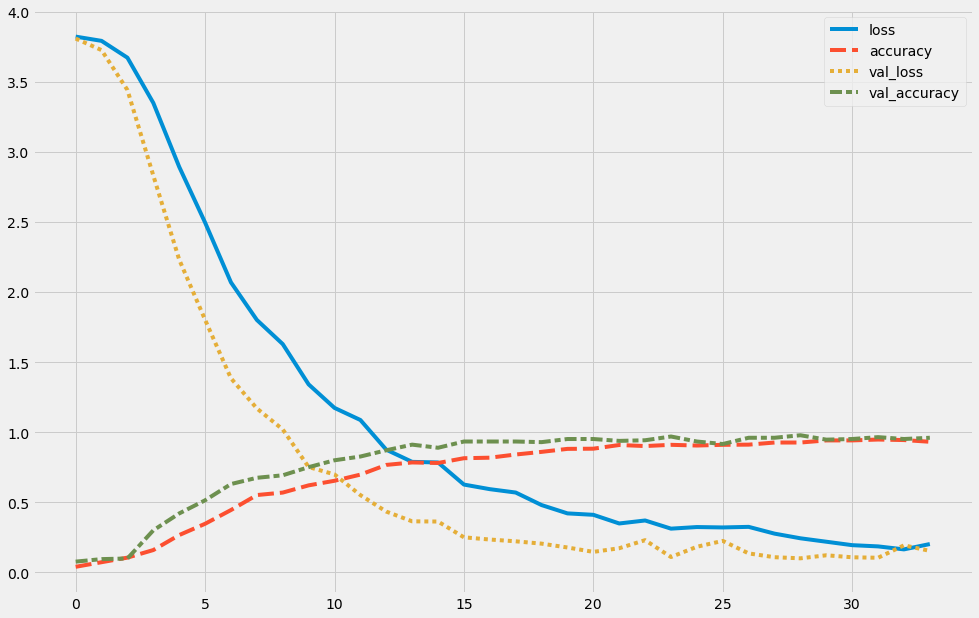

,loss,accuracy,val_loss,val_accuracy
29,0.217874,0.940880,0.121172,0.946429
30,0.193319,0.940880,0.106804,0.950893
31,0.184536,0.947170,0.103427,0.964286
32,0.163283,0.943396,0.192224,0.950893
33,0.201310,0.931250,0.152518,0.959821


In [18]:
plot_keras_fit_history(resultsc1, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [19]:
%%time
test_batch = next(X_test_generator)
image_class_evaluation(modelc1, test_batch[0], test_batch[1])

Accuracy: 0.90625
Balanced Accuracy: 0.898550724637681
CPU times: user 65.8 ms, sys: 13.2 ms, total: 79 ms
Wall time: 77.4 ms


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(0.90625, 0.898550724637681)

### CNN With Transfer Learning

In [29]:
modelkuzushiji = models.load_model('model_backups/kuzushiji/model9-21')

In [30]:
layers = modelkuzushiji.layers[:-2] + [Dense(40, "relu"), Dense(46, activation='softmax')]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.00005), "metrics":['accuracy']}
modelc2 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)        

In [31]:
for layer in modelc2.layers[0:3]:
    layer.trainable = False

In [32]:
backups = ModelCheckpoint("model_backups/choubenkyo/modelc2-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

resultsc2 = modelc2.fit(X_train_generator, epochs=200, steps_per_epoch=20, validation_data=X_val_generator, validation_steps=5, callbacks=[backups, stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 5 steps
Epoch 1/200
20/20 [==============================] - 1s 64ms/step - loss: 5.4996 - accuracy: 0.0157 - val_loss: 4.5607 - val_accuracy: 0.0437
Epoch 2/200
20/20 [==============================] - 1s 42ms/step - loss: 4.2354 - accuracy: 0.0378 - val_loss: 3.7387 - val_accuracy: 0.0625
Epoch 3/200
20/20 [==============================] - 1s 47ms/step - loss: 3.7128 - accuracy: 0.0740 - val_loss: 3.3251 - val_accuracy: 0.1437
Epoch 4/200
20/20 [==============================] - 1s 41ms/step - loss: 3.3593 - accuracy: 0.1213 - val_loss: 3.0193 - val_accuracy: 0.2250
Epoch 5/200
20/20 [==============================] - 1s 42ms/step - loss: 3.0564 - accuracy: 0.2031 - val_loss: 2.7470 - val_accuracy: 0.3000
Epoch 6/200
20/20 [==============================] - 1s 43ms/step - loss: 2.8462 - accuracy: 0.2656 - val_loss: 2.4766 - val_accuracy: 0.4375
Epoch 7/200
20/20 [==============================] - 1s 4

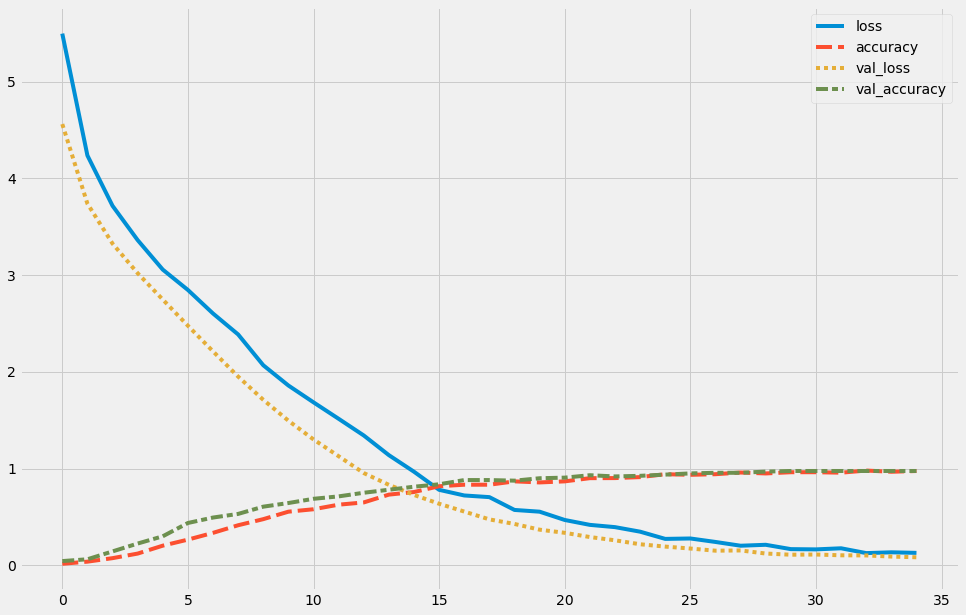

,loss,accuracy,val_loss,val_accuracy
30,0.164688,0.962205,0.111463,0.975
31,0.176036,0.957480,0.103599,0.975
32,0.126237,0.979528,0.102238,0.975
33,0.134424,0.966929,0.090350,0.975
34,0.128607,0.974803,0.083062,0.975


In [33]:
plot_keras_fit_history(resultsc2, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [34]:
%%time
test_batch = next(X_test_generator)
image_class_evaluation(modelc2, test_batch[0], test_batch[1])

Accuracy: 0.9375
Balanced Accuracy: 0.9444444444444443
CPU times: user 69 ms, sys: 3 ms, total: 72 ms
Wall time: 69.6 ms


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(0.9375, 0.9444444444444443)

### The LSTM

Before converting the data, the labels need to be cleaned up a bit.

In [35]:
#Creating a dictionary that will be used to map the character id to an index.
class_list_label_dict = {key:value for key, value in class_list.reset_index()[["char_id","index"]].to_numpy()}

#Mapping to the index so that each label is an integer.
choubenkyo_labels = choubenkyo_raw_labels.map(class_list_label_dict)

In [36]:
def preprocess_lstm_pipeline(array, labels, test_size=None, val_size=None, random_seed=None):

    nobs, sequence_length, nfeatures = array.shape

    #App provides possible values range from -1 to 1. This will standardize the data for machine learning, while
    #also preserving information present in the relative size of a drawing.
    scaled_array = (array.copy() + 1)/2
    labels = labels.copy()
    
    array1d = scaled_array.reshape([nobs, -1])
    
    if test_size and val_size:
        print("Performing a train, test, validation split.")
        X_int, X_test, y_int, y_test = train_test_split(array1d, labels, test_size=test_size, random_state=random_seed)
        X_train, X_val, y_train, y_val = train_test_split(X_int, y_int, test_size=val_size, random_state=random_seed)
        return X_train.reshape([-1, sequence_length, nfeatures]), X_val.reshape([-1, sequence_length, nfeatures]), X_test.reshape([-1, sequence_length, nfeatures]), to_categorical(y_train), to_categorical(y_val), to_categorical(y_test)
    if test_size or val_size:
        print("Performing a train, test split.")
        test_size = max([test_size, val_size])
        X_train, X_test, y_train, y_test = train_test_split(array1d, labels, test_size=test_size, random_state=random_seed)
        return X_train.reshape([-1, sequence_length, nfeatures]), X_test.reshape([-1, sequence_length, nfeatures]), to_categorical(y_train), to_categorical(y_test)
    else:
        print("Skipping train, test, split")
        return scaled_array, to_categorical(labels)
    
        #One hot encodes the labels in order to be fit to the lstm.
    labels = to_categorical(labels.copy())

In [37]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_lstm_pipeline(choubenkyo_data, choubenkyo_labels, .2, .1, random_seed=SEED)

Performing a train, test, validation split.


In [38]:
class_weights = class_weight.compute_class_weight(
           'balanced',
            classes = np.unique(np.argmax(y_train, axis = 1)), 
            y = np.argmax(y_train, axis = 1))

In [39]:
layers = [LSTM(100, input_shape=(120,max_features)),
          Dropout(0.1),
          Dense(40, activation='relu'),
          Dense(46, activation='softmax'),
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0001), "metrics":['accuracy']}
modelc3 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               72400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 40)                4040      
_________________________________________________________________
dense_11 (Dense)             (None, 46)                1886      
Total params: 78,326
Trainable params: 78,326
Non-trainable params: 0
_________________________________________________________________


In [40]:
backupsc3 = ModelCheckpoint("model_backups/kanji/modelc3-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=8, restore_best_weights=True)

resultsc3 = modelc3.fit(X_train, y_train, epochs=200, batch_size=5, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[backupsc3, stopping])

Train on 906 samples, validate on 101 samples
Epoch 1/200
906/906 [==============================] - 4s 5ms/sample - loss: 3.8310 - accuracy: 0.0254 - val_loss: 3.8174 - val_accuracy: 0.0297
Epoch 2/200
906/906 [==============================] - 3s 4ms/sample - loss: 3.8122 - accuracy: 0.0221 - val_loss: 3.7941 - val_accuracy: 0.0198
Epoch 3/200
906/906 [==============================] - 3s 3ms/sample - loss: 3.7944 - accuracy: 0.0309 - val_loss: 3.7642 - val_accuracy: 0.0396
Epoch 4/200
906/906 [==============================] - 3s 4ms/sample - loss: 3.7123 - accuracy: 0.0607 - val_loss: 3.6960 - val_accuracy: 0.0891
Epoch 5/200
906/906 [==============================] - 3s 4ms/sample - loss: 3.5751 - accuracy: 0.0773 - val_loss: 3.5160 - val_accuracy: 0.1980
Epoch 6/200
906/906 [==============================] - 3s 3ms/sample - loss: 3.4900 - accuracy: 0.0938 - val_loss: 3.4834 - val_accuracy: 0.1485
Epoch 7/200
906/906 [==============================] - 3s 4ms/sample - loss: 3.3907 

In [41]:
%%time
image_class_evaluation(modelc3, X_test, y_test)

Accuracy: 0.8611111111111112
Balanced Accuracy: 0.8536231884057971
CPU times: user 238 ms, sys: 5.02 ms, total: 243 ms
Wall time: 212 ms


(0.8611111111111112, 0.8536231884057971)

### LSTM Test 2

In [42]:
layers = [LSTM(200, input_shape=(120,max_features)),
          Dropout(0.1),
          Dense(40, activation='relu'),
          Dense(46, activation='softmax'),
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0001), "metrics":['accuracy']}
modelc4 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               224800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 40)                8040      
_________________________________________________________________
dense_13 (Dense)             (None, 46)                1886      
Total params: 234,726
Trainable params: 234,726
Non-trainable params: 0
_________________________________________________________________


In [32]:
backups = ModelCheckpoint("model_backups/kanji/modelc4-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=8, restore_best_weights=True)

resultsc4 = modelc4.fit(X_train, y_train, epochs=200, batch_size=5, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[backups, stopping])

Train on 873 samples, validate on 98 samples
Epoch 1/200
873/873 [==============================] - 4s 5ms/sample - loss: 3.8293 - accuracy: 0.0252 - val_loss: 3.8286 - val_accuracy: 0.0102
Epoch 2/200
873/873 [==============================] - 3s 4ms/sample - loss: 3.8055 - accuracy: 0.0275 - val_loss: 3.7910 - val_accuracy: 0.0102
Epoch 3/200
873/873 [==============================] - 3s 4ms/sample - loss: 3.7844 - accuracy: 0.0538 - val_loss: 3.7502 - val_accuracy: 0.0510
Epoch 4/200
873/873 [==============================] - 3s 4ms/sample - loss: 3.7427 - accuracy: 0.0389 - val_loss: 3.8110 - val_accuracy: 0.0000e+00
Epoch 5/200
873/873 [==============================] - 3s 4ms/sample - loss: 3.7196 - accuracy: 0.0550 - val_loss: 3.7532 - val_accuracy: 0.0306
Epoch 6/200
873/873 [==============================] - 3s 4ms/sample - loss: 3.5278 - accuracy: 0.1111 - val_loss: 3.8397 - val_accuracy: 0.0000e+00
Epoch 7/200
873/873 [==============================] - 3s 4ms/sample - loss: 

In [33]:
%%time
image_class_evaluation(modelc3, X_test, y_test)

Accuracy: 0.9176954732510288
Balanced Accuracy: 0.9166313932980596
CPU times: user 67.6 ms, sys: 20.9 ms, total: 88.5 ms
Wall time: 61.2 ms


(0.9176954732510288, 0.9166313932980596)

### CNN Full test

In [31]:
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=4,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
test_generator = ImageDataGenerator(rescale=1./255)

In [32]:
X_train_generator = train_generator.flow_from_directory(rendered_split_paths["train"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)
X_val_generator = test_generator.flow_from_directory(rendered_split_paths["val"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)
X_test_generator = test_generator.flow_from_directory(rendered_split_paths["test"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)

Found 1519 images belonging to 108 classes.
Found 445 images belonging to 108 classes.
Found 278 images belonging to 108 classes.


In [33]:
layers = [Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(32 ,32,  1)),
          Conv2D(32, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(46, "relu"),
          Dense(108, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0001), "metrics":['accuracy']}
modelc5 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 128)        

In [36]:
backups = ModelCheckpoint("model_backups/choubenkyo/modelc5-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

resultsc5 = modelc5.fit(X_train_generator, epochs=200, steps_per_epoch=47, validation_data=X_val_generator, validation_steps=13, callbacks=[backups, stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 47 steps, validate for 13 steps
Epoch 1/200
47/47 [==============================] - 1s 29ms/step - loss: 0.6694 - accuracy: 0.8016 - val_loss: 0.5793 - val_accuracy: 0.8173
Epoch 2/200
47/47 [==============================] - 1s 27ms/step - loss: 0.6216 - accuracy: 0.8030 - val_loss: 0.5157 - val_accuracy: 0.8245
Epoch 3/200
47/47 [==============================] - 1s 27ms/step - loss: 0.6391 - accuracy: 0.8063 - val_loss: 0.5165 - val_accuracy: 0.8269
Epoch 4/200
47/47 [==============================] - 1s 27ms/step - loss: 0.6281 - accuracy: 0.8036 - val_loss: 0.5816 - val_accuracy: 0.8173
Epoch 5/200
47/47 [==============================] - 1s 27ms/step - loss: 0.5639 - accuracy: 0.8191 - val_loss: 0.5360 - val_accuracy: 0.8053
Epoch 6/200
47/47 [==============================] - 1s 30ms/step - loss: 0.5792 - accuracy: 0.8151 - val_loss: 0.5218 - val_accuracy: 0.8269
Epoch 7/200
47/47 [==============================] - 1s 

In [37]:
%%time
test_batch = next(X_test_generator)
image_class_evaluation(modelc5, test_batch[0], test_batch[1])

Accuracy: 0.8125
Balanced Accuracy: 0.8214285714285714
CPU times: user 62.1 ms, sys: 2.04 ms, total: 64.2 ms
Wall time: 63.6 ms


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(0.8125, 0.8214285714285714)

### CNN Transfer full test

In [48]:
modelkuzushiji = models.load_model('model_backups/kuzushiji/model9-21')

In [49]:
layers = modelkuzushiji.layers[:-2] + [Dense(46, "relu"), Dense(108, activation='softmax')]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.00005), "metrics":['accuracy']}
modelc6 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)        

In [50]:
for layer in modelc6.layers[0:3]:
    layer.trainable = False

In [51]:
backups = ModelCheckpoint("model_backups/choubenkyo/modelc6-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

resultsc6 = modelc6.fit(X_train_generator, epochs=200, steps_per_epoch=47, validation_data=X_val_generator, validation_steps=13, callbacks=[backups, stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 47 steps, validate for 13 steps
Epoch 1/200
47/47 [==============================] - 2s 34ms/step - loss: 5.3954 - accuracy: 0.0101 - val_loss: 4.7671 - val_accuracy: 0.0168
Epoch 2/200
47/47 [==============================] - 1s 24ms/step - loss: 4.6444 - accuracy: 0.0182 - val_loss: 4.3785 - val_accuracy: 0.0697
Epoch 3/200
47/47 [==============================] - 1s 24ms/step - loss: 4.3376 - accuracy: 0.0558 - val_loss: 4.0984 - val_accuracy: 0.0938
Epoch 4/200
47/47 [==============================] - 1s 24ms/step - loss: 4.0918 - accuracy: 0.0854 - val_loss: 3.7820 - val_accuracy: 0.1490
Epoch 5/200
47/47 [==============================] - 1s 24ms/step - loss: 3.7494 - accuracy: 0.1621 - val_loss: 3.4224 - val_accuracy: 0.2284
Epoch 6/200
47/47 [==============================] - 1s 24ms/step - loss: 3.4530 - accuracy: 0.2161 - val_loss: 3.0547 - val_accuracy: 0.3053
Epoch 7/200
47/47 [==============================] - 1s 

In [52]:
%%time
test_batch = next(X_test_generator)
image_class_evaluation(modelc6, test_batch[0], test_batch[1])

Accuracy: 0.90625
Balanced Accuracy: 0.8928571428571429
CPU times: user 74.1 ms, sys: 8.23 ms, total: 82.3 ms
Wall time: 80.1 ms


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(0.90625, 0.8928571428571429)

### Full LSTM

In [53]:
#Creating a dictionary that will be used to map the character id to an index.
class_list_label_dict = {key:value for key, value in class_list.reset_index()[["char_id","index"]].to_numpy()}

#Mapping to the index so that each label is an integer.
choubenkyo_labels = choubenkyo_raw_labels.map(class_list_label_dict)

In [62]:
layers = [LSTM(200, input_shape=(120,max_features)),
          Dropout(0.1),
          Dense(48, activation='relu'),
          Dense(108, activation='softmax'),
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0001), "metrics":['accuracy']}
modelc7 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               224800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 48)                9648      
_________________________________________________________________
dense_25 (Dense)             (None, 108)               5292      
Total params: 239,740
Trainable params: 239,740
Non-trainable params: 0
_________________________________________________________________


In [63]:
backups = ModelCheckpoint("model_backups/kanji/modelc7-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=8, restore_best_weights=True)

resultsc7 = modelc7.fit(X_train, y_train, epochs=200, batch_size=5, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[backups, stopping])

Train on 2037 samples, validate on 227 samples
Epoch 1/200
2037/2037 [==============================] - 6s 3ms/sample - loss: 4.6812 - accuracy: 0.0103 - val_loss: 4.6715 - val_accuracy: 0.0220
Epoch 2/200
2037/2037 [==============================] - 4s 2ms/sample - loss: 4.6605 - accuracy: 0.0128 - val_loss: 4.6420 - val_accuracy: 0.0088
Epoch 3/200
2037/2037 [==============================] - 5s 2ms/sample - loss: 4.6154 - accuracy: 0.0255 - val_loss: 4.7641 - val_accuracy: 0.0176
Epoch 4/200
2037/2037 [==============================] - 4s 2ms/sample - loss: 4.4751 - accuracy: 0.0363 - val_loss: 4.3879 - val_accuracy: 0.0617
Epoch 5/200
2037/2037 [==============================] - 5s 2ms/sample - loss: 4.2161 - accuracy: 0.0707 - val_loss: 4.0162 - val_accuracy: 0.0793
Epoch 6/200
2037/2037 [==============================] - 5s 2ms/sample - loss: 3.8257 - accuracy: 0.1149 - val_loss: 3.5696 - val_accuracy: 0.1189
Epoch 7/200
2037/2037 [==============================] - 5s 2ms/sample 

In [65]:
%%time
image_class_evaluation(modelc7, X_test, y_test)

Accuracy: 0.8765432098765432
Balanced Accuracy: 0.8944444444444444
CPU times: user 307 ms, sys: 28 ms, total: 335 ms
Wall time: 271 ms


(0.8765432098765432, 0.8944444444444444)